In [23]:
# | hidden: true
# | echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

## Confidence Intervals

We have talked about quantifying uncertainty with $p$-values (the probability of observing the data under a some hypothesis). But oftentimes we want to quantify uncertainty in a different way: by estimating the range of values that some parameter is likely to take. So, rather than asking "how likely is it that the average is $\mu=0$?" we might ask "what is a plausible range of values for the average?"

This range is called a **confidence interval**. Like in hypothesis testing, we can choose a risk level $\alpha$ (e.g., 5%). 
The confidence interval, like a hypothesis test, is computed based on a sample -- so sometimes it is incorrect! 

Mathematically, we the confidence interval for a parameter $\theta$ is defined as the range of values bounded by $[L, U]$ that are likely to contain the true value of the parameter with probability $1-\alpha$:
$$
\mathbb{P}(\theta \in [L, U]) = 1 - \alpha
$$

There is an important distinction to make here: $\theta$ is not the thing that changes! In fact, we can't compute $\theta$ - it is a theoretical property of the population. What changes is the sample we draw from the population, and the confidence interval is computed based on that sample. So, if we draw a different sample, we will get a different confidence interval.


## Uncertainty without models

So far, we've emphasized the importance of developing **models** of data-generating processes in order to quantify randomness and uncertainty. If you know something about the underlying process that generates your data, you can pick an appropriate statistical model and use it to sample from the distribution, simulate new data, and evaluate hypotheses. The CLT is a powerful tool because even when we don't know what a good model of the data-generating process is, we can often use the normal distribution as an approximation for the distribution of sample means.

However, there are still many situations where we don't know enough about the DGP to confidently specify a model. In these cases, we can still use statistical techniques to evaluate hypotheses about the data. The idea is that if we don't have any knowledge about the DGP, we rely on the only information we have: the data itself. 

### Resampling methods

How did we get a dataset in the first place? Recall that every dataset is a sample from some underlying distribution.

What is the main difference between a sample and a population? A sample is a subset of the population, and it is usually much smaller than the population. The sample might not cover all the "edge cases" or rare events that are present in the population, or certain outcomes might be overrepresented (you *could* flip a fair coin 10 times and get 10 heads, even if it is unlikely). But as we have seen, the bigger the sample is the more it tends to represent the population well.

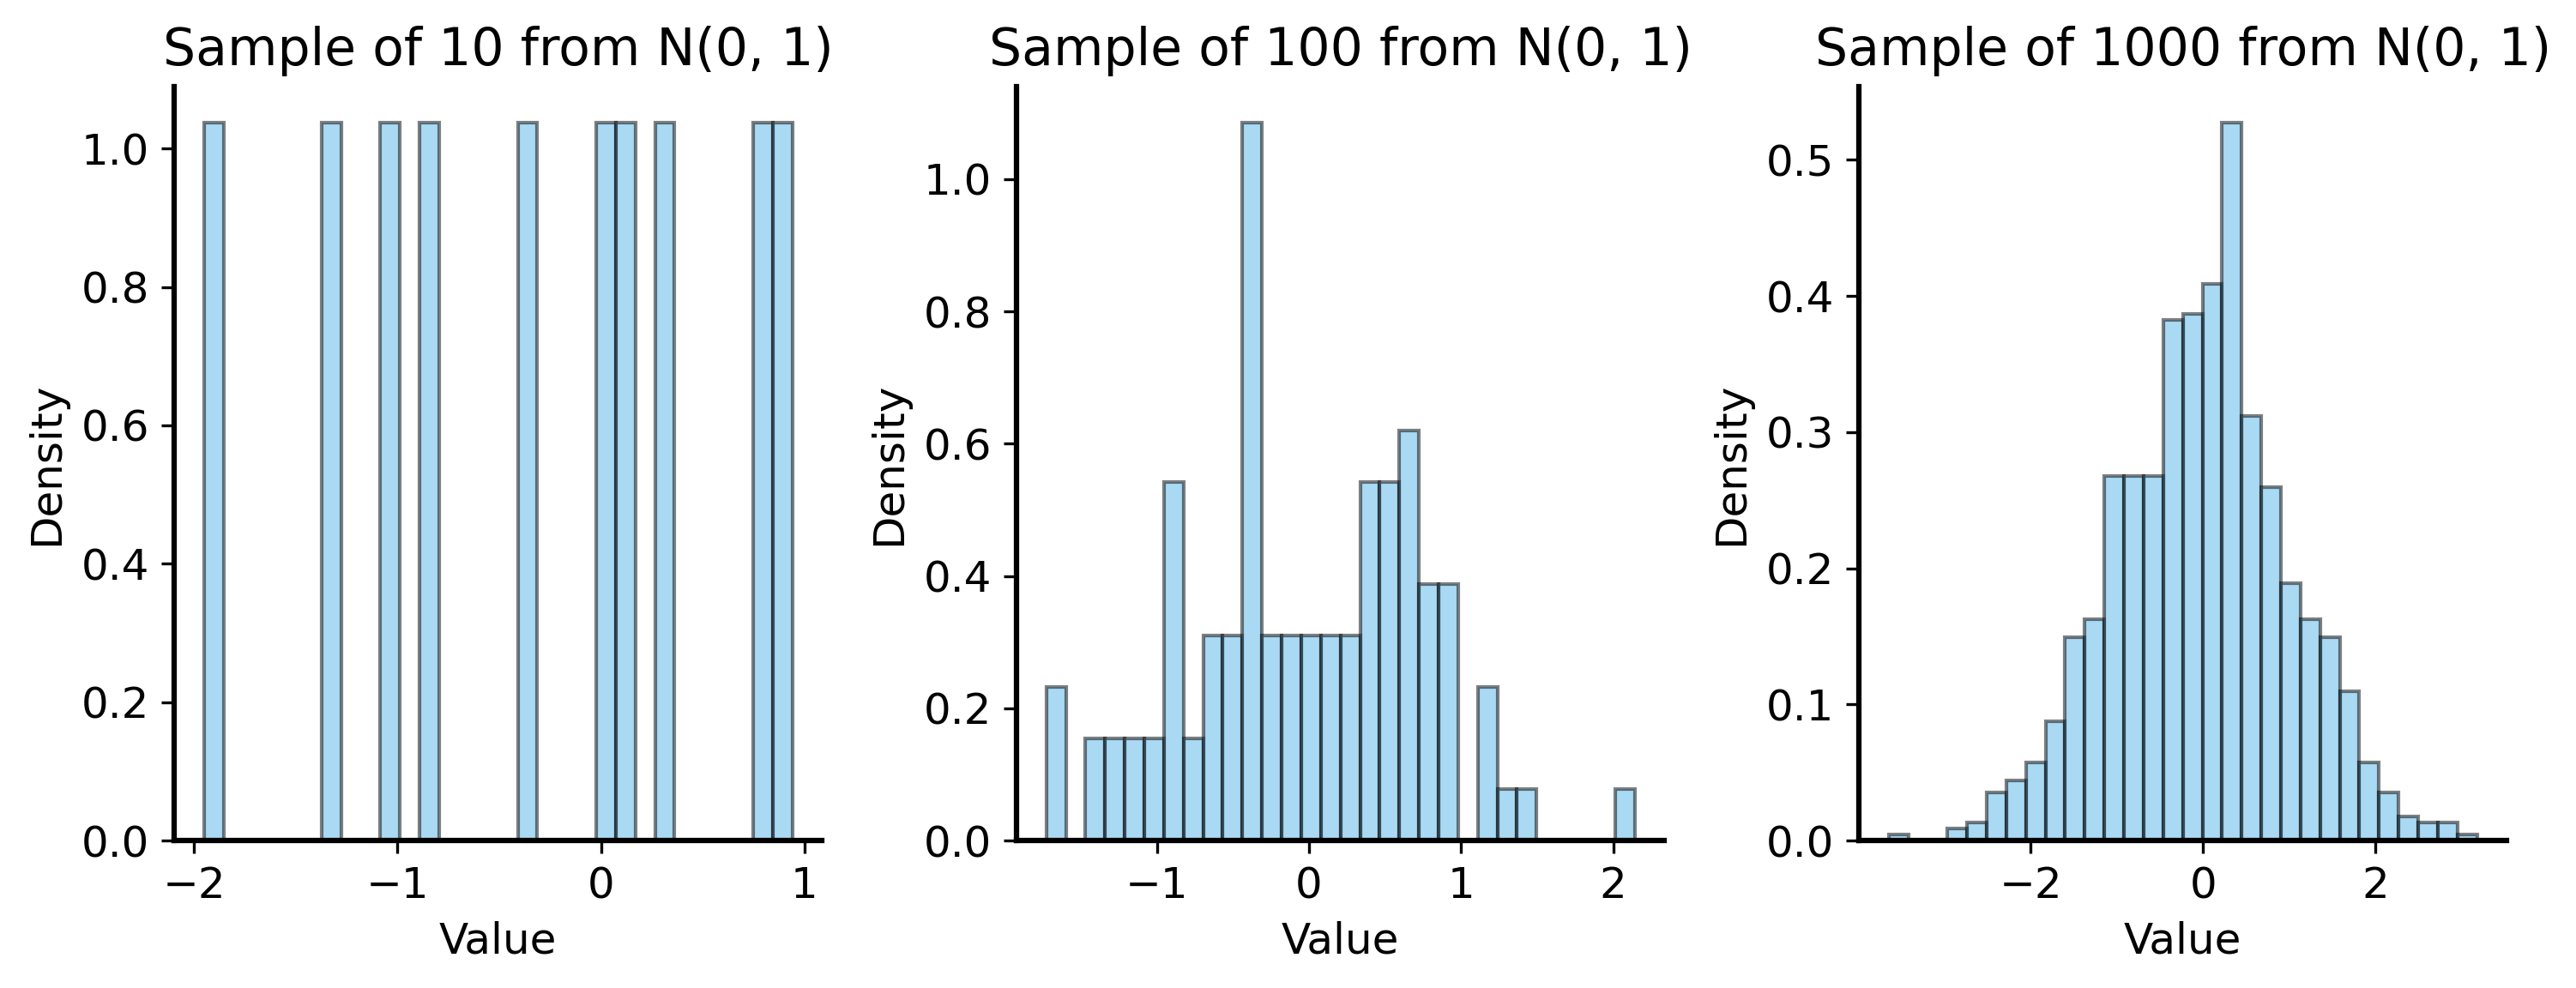

In [24]:
# sample data from a normal distribution
rng = np.random.default_rng(42)  # for reproducibility
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i, n_samples in enumerate([10, 100, 1000]):
    sample = rng.normal(loc=0, scale=1, size=n_samples)
    ax[i].hist(sample, bins=30, density=True, alpha=0.5)
    ax[i].set_title(f"Sample of {n_samples} from N(0, 1)")
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Density")
plt.tight_layout()
plt.show()

If the sample starts to look like the population... then maybe we can just use the sample itself as a proxy for the population? This is the idea behind **resampling methods**. When the sample is pretty large, we can **sub-sample** from the original dataset as though it were the population, and use the sub-samples to estimate properties of the population.

Let's try this with the example above. Treating each of the histograms as a proxy for the population, we will sub-sample (with replacement) from the sample 1000 times to create new samples, and see what they look like.

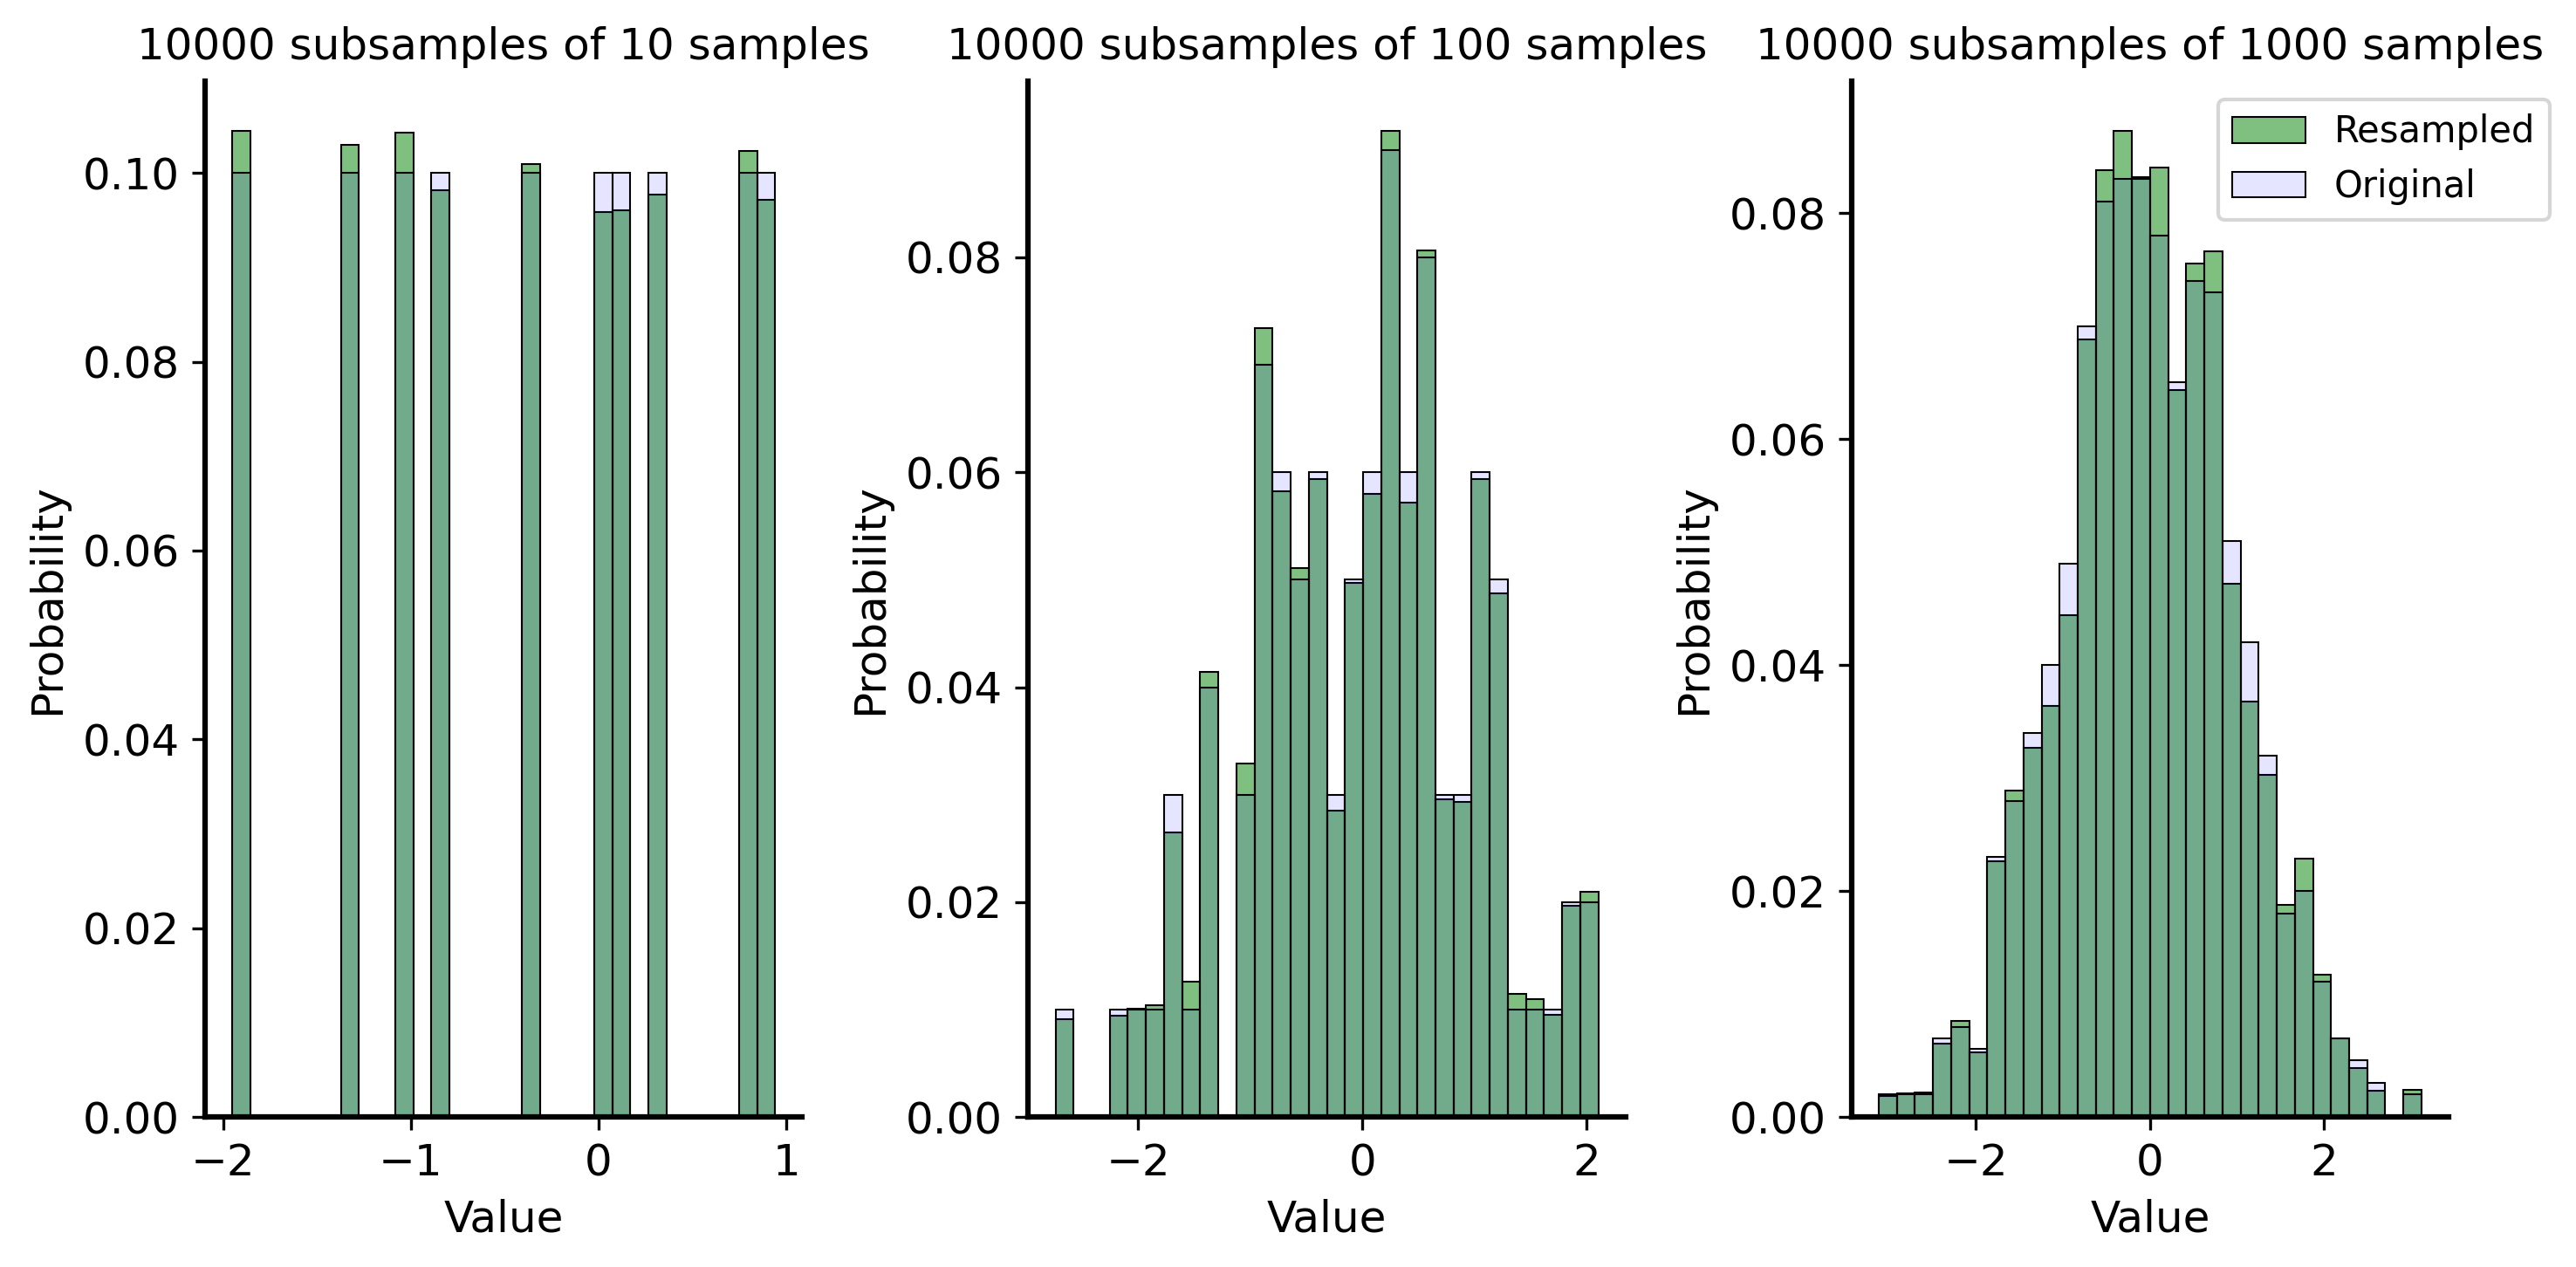

In [25]:
rng = np.random.default_rng(42)  # for reproducibility
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i, n_samples in enumerate([10, 100, 1000]):
    sample = rng.normal(loc=0, scale=1, size=n_samples)
    # choose samples at random with replacement
    resample = rng.choice(sample, size=10000, replace=True)
    sns.histplot(resample, bins=30, stat="probability", alpha=0.5, color='green', label='Resampled', ax=ax[i])
    sns.histplot(sample, bins=30, stat="probability", alpha=0.1, color='blue', label='Original', ax=ax[i])
    ax[i].set_title(f"10000 subsamples of {n_samples} samples", fontsize=12)
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Probability")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

As it turns out, the distribution of the resampled data is very similar to the original sample. So if the original sample is similar to the true population distribution, the resampled distribution will retain that similarity. 

## Bootstrapping
Bootstrapping is a specific type of resampling method that allows us to estimate the sampling distribution of any test statistic (e.g., mean, median, variance) by repeatedly resampling with replacement from the observed data. This bootstrapped distribution can then be used to compute confidence intervals or perform hypothesis tests without making *any* assumptions about the underlying distribution of the data! 

Let's generate a sample from a normal distribution with known parameters $\mu=3.2$ and $\sigma=1.5$. 
Then, we will use bootstrapping to estimate the mean and variance of the population from the sample.

Bootstrapped mean: 3.16
Bootstrapped standard deviation: 1.48


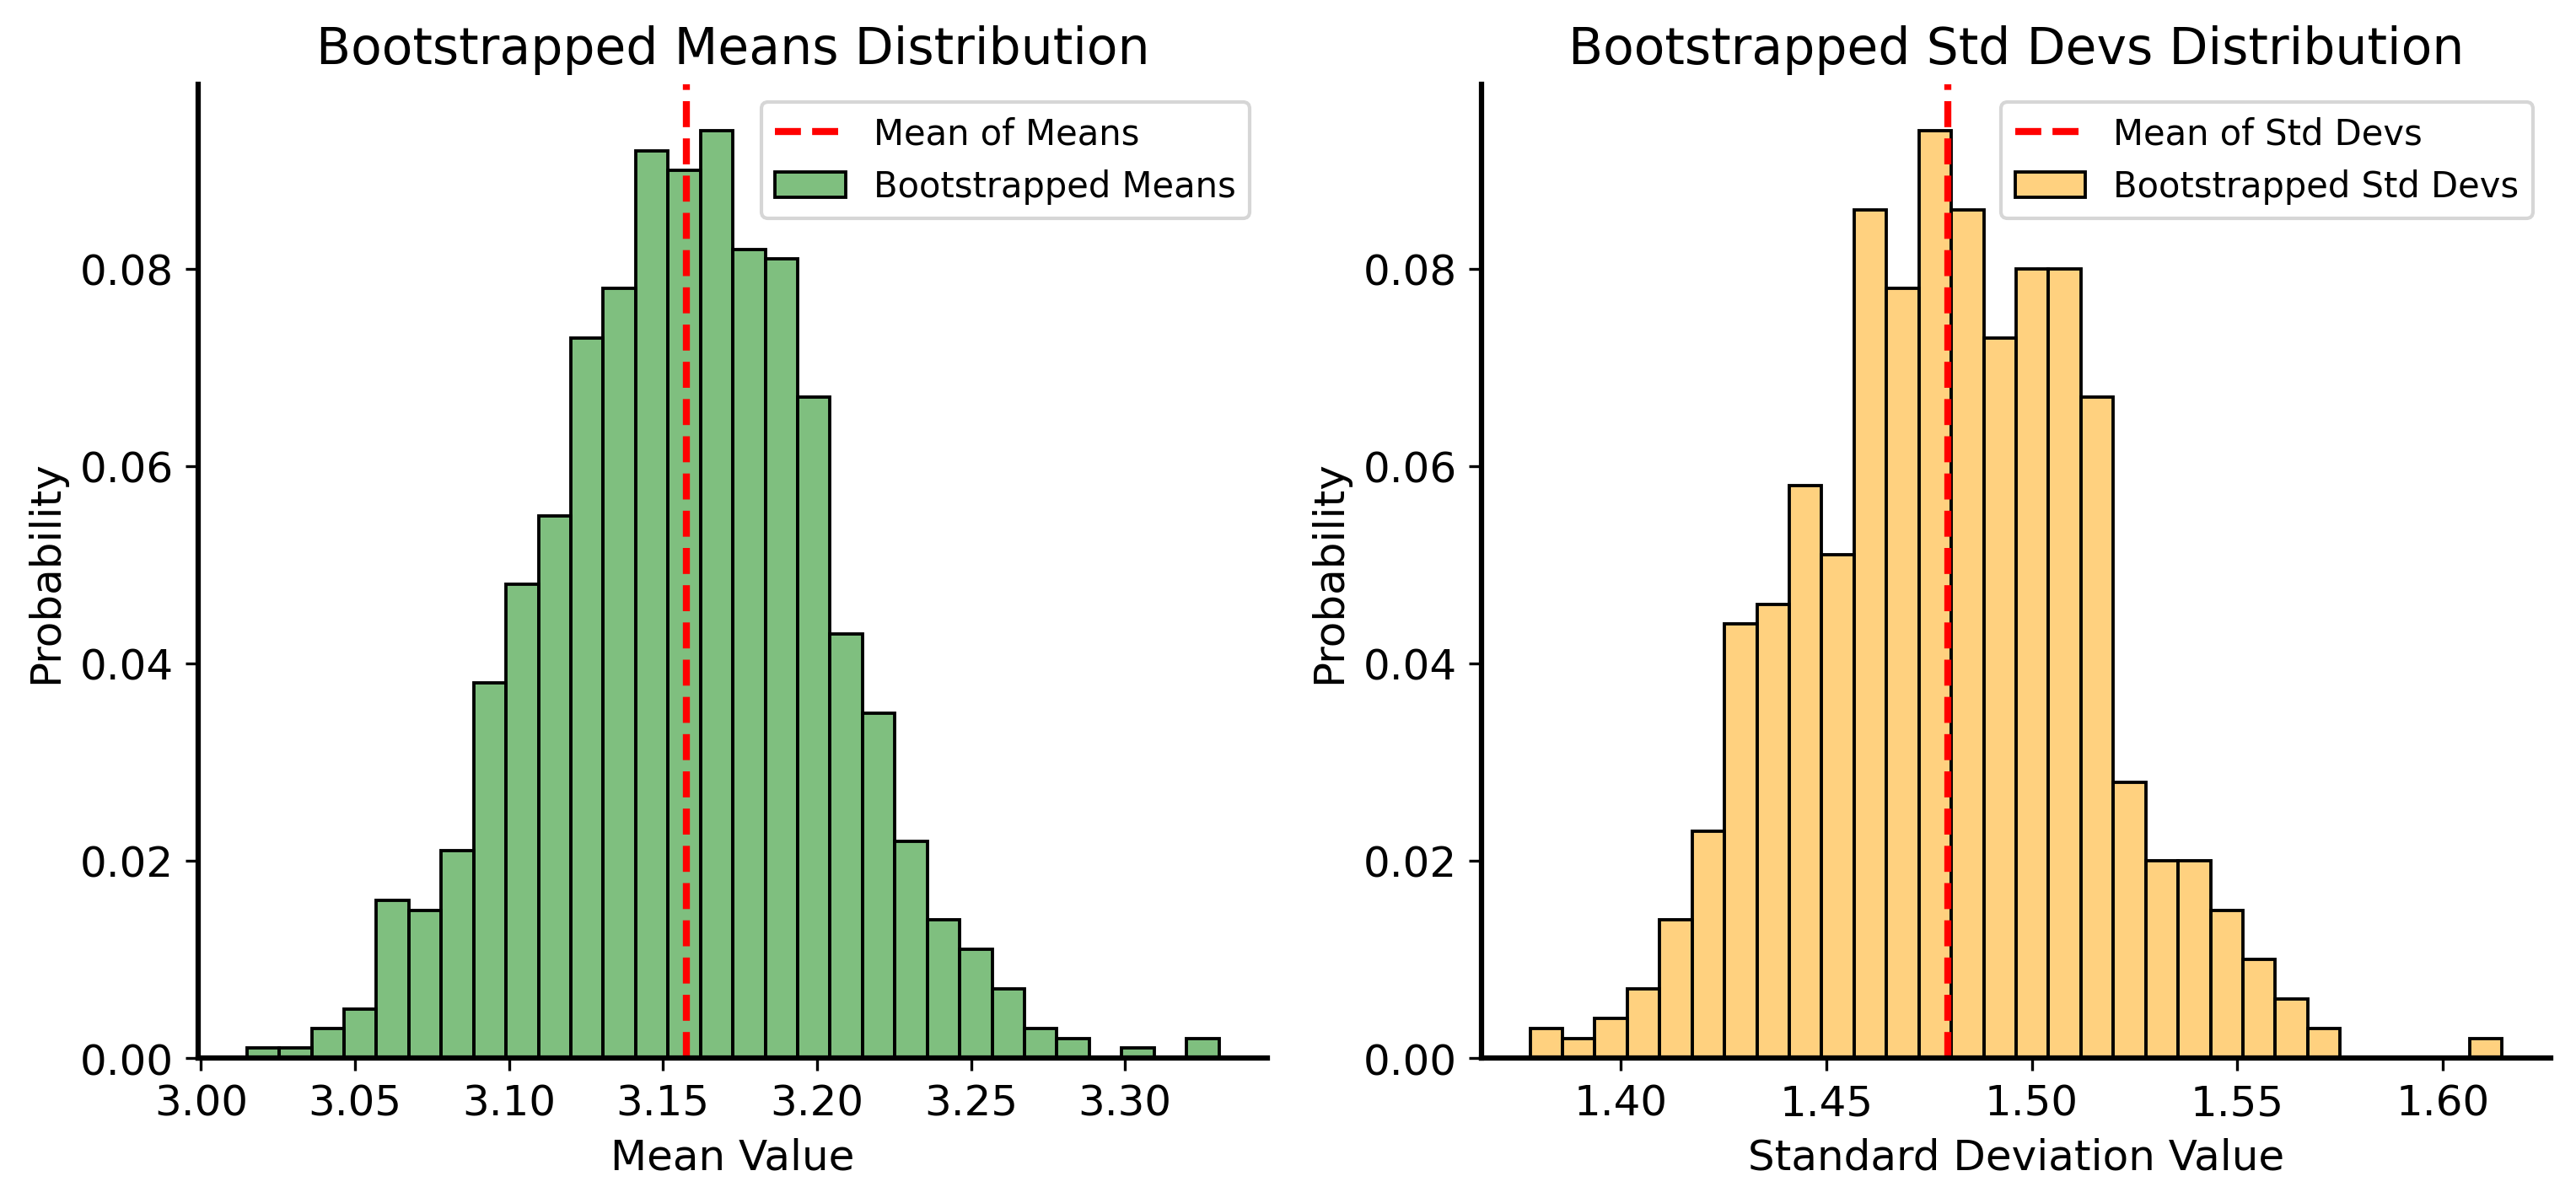

In [33]:
rng = np.random.default_rng(42)

sample_size = 1000
n_bootstraps = 1000

original_sample = rng.normal(loc=3.2, scale=1.5, size=sample_size)

bootstrapped_means = []
bootstrapped_std = []
for _ in range(n_bootstraps):
    resample = rng.choice(original_sample, size=sample_size, replace=True)
    bootstrapped_means.append(np.mean(resample))
    bootstrapped_std.append(np.std(resample, ddof=1))
bootstrapped_means = np.array(bootstrapped_means)
bootstrapped_std = np.array(bootstrapped_std)
print(f"Bootstrapped mean: {np.mean(bootstrapped_means):.2f}")
print(f"Bootstrapped standard deviation: {np.mean(bootstrapped_std):.2f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(bootstrapped_means, bins=30, stat="probability", alpha=0.5, color='green', label='Bootstrapped Means', ax=ax[0])
sns.histplot(bootstrapped_std, bins=30, stat="probability", alpha=0.5, color='orange', label='Bootstrapped Std Devs', ax=ax[1])
ax[0].axvline(np.mean(bootstrapped_means), color='red', linestyle='--', label='Mean of Means')
ax[1].axvline(np.mean(bootstrapped_std), color='red', linestyle='--', label='Mean of Std Devs')
ax[0].legend()
ax[1].legend()
ax[0].set_title("Bootstrapped Means Distribution")
ax[1].set_title("Bootstrapped Std Devs Distribution")
ax[0].set_xlabel("Mean Value")
ax[1].set_xlabel("Standard Deviation Value")
ax[0].set_ylabel("Probability")
ax[1].set_ylabel("Probability")
plt.show()

Here is the real power of bootstrapping, though: because we have the whole distribution of the resampled data, we can compute confidence intervals any statistic by looking at at different percentiles of the resampled distribution. For example, we can compute a 95% confidence interval for the mean by taking the 2.5th and 97.5th percentiles of the resampled means.

95% Confidence Interval for the Mean: (3.07, 3.25)
95% Confidence Interval for the Standard Deviation: (1.41, 1.55)


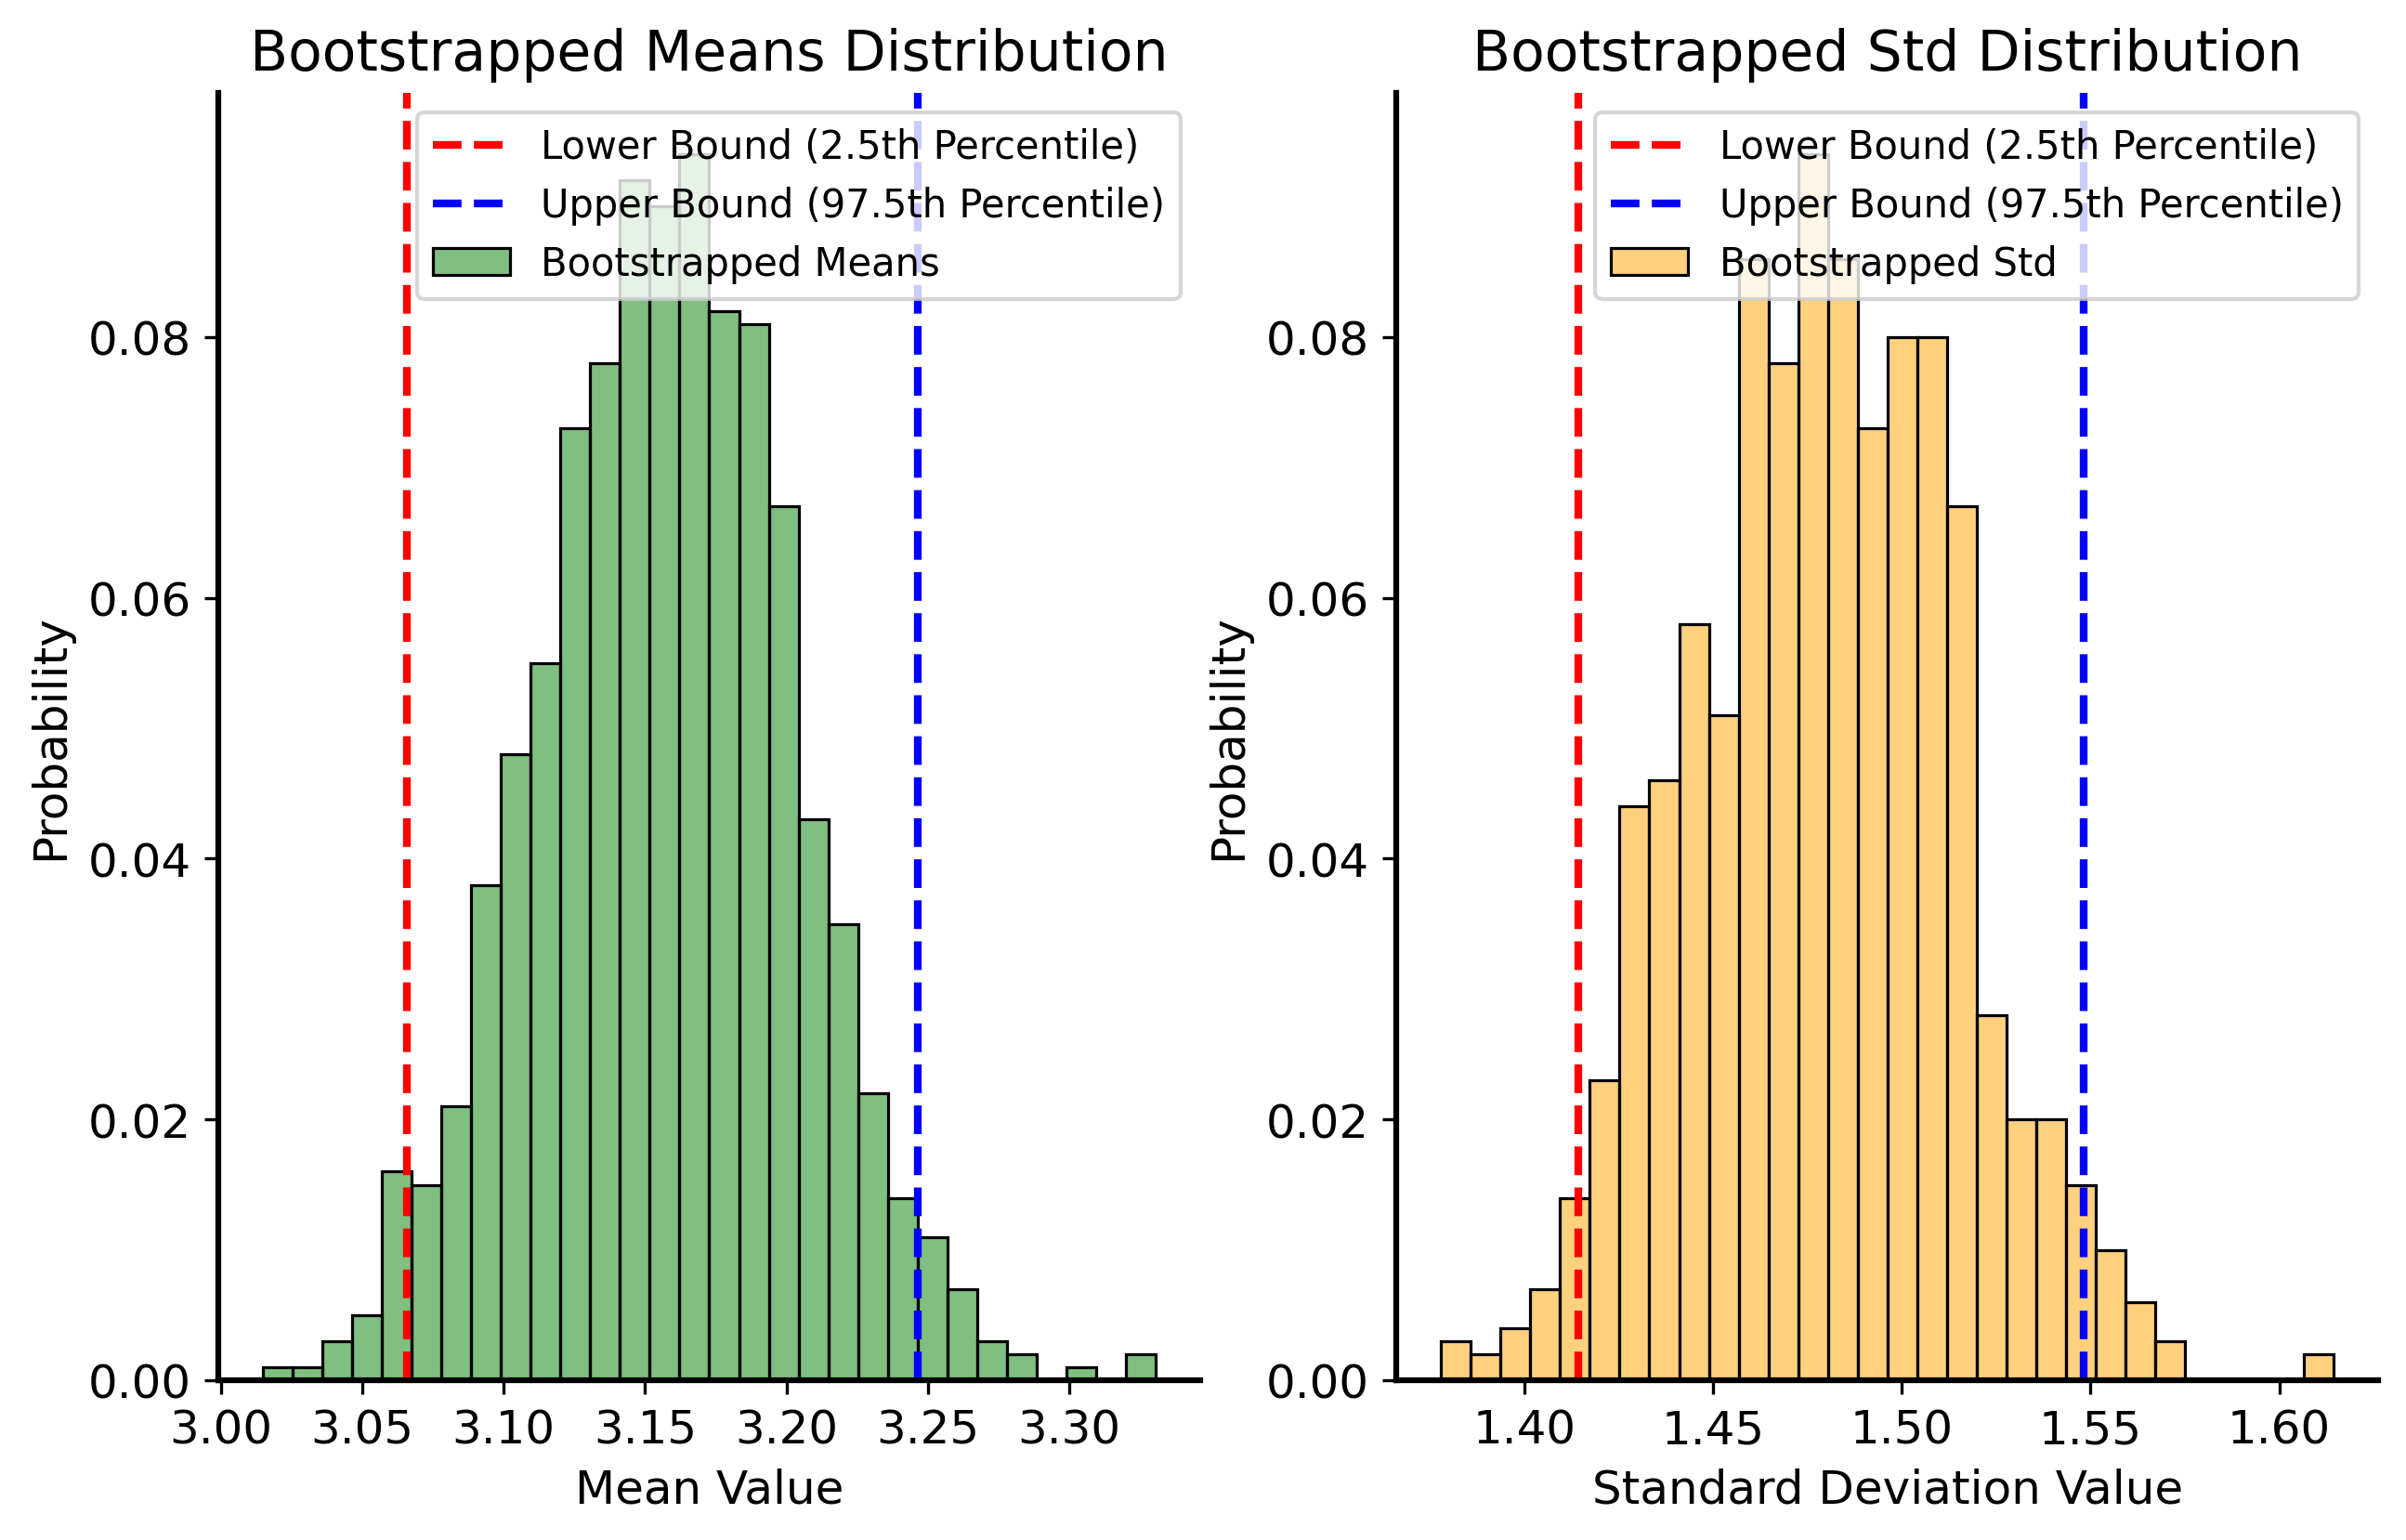

In [42]:
lower_bound_mean = np.percentile(bootstrapped_means, 2.5)
upper_bound_mean = np.percentile(bootstrapped_means, 97.5)
print(f"95% Confidence Interval for the Mean: ({lower_bound_mean:.2f}, {upper_bound_mean:.2f})")
lower_bound_std = np.percentile(bootstrapped_std, 2.5)
upper_bound_std = np.percentile(bootstrapped_std, 97.5)
print(f"95% Confidence Interval for the Standard Deviation: ({lower_bound_std:.2f}, {upper_bound_std:.2f})")

# plot the distribution of bootstrapped means and std with confidence intervals
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.histplot(bootstrapped_means, bins=30, stat="probability", alpha=0.5, color='green', label='Bootstrapped Means', ax=ax[0])
ax[0].axvline(lower_bound_mean, color='red', linestyle='--', label='Lower Bound (2.5th Percentile)')
ax[0].axvline(upper_bound_mean, color='blue', linestyle='--', label='Upper Bound (97.5th Percentile)')
ax[0].set_title("Bootstrapped Means Distribution")
ax[0].set_xlabel("Mean Value")
ax[0].set_ylabel("Probability")
ax[0].legend()

sns.histplot(bootstrapped_std, bins=30, stat="probability", alpha=0.5, color='orange', label='Bootstrapped Std', ax=ax[1])
ax[1].axvline(lower_bound_std, color='red', linestyle='--', label='Lower Bound (2.5th Percentile)')
ax[1].axvline(upper_bound_std, color='blue', linestyle='--', label='Upper Bound (97.5th Percentile)')
ax[1].set_title("Bootstrapped Std Distribution")
ax[1].set_xlabel("Standard Deviation Value")
ax[1].set_ylabel("Probability")
ax[1].legend()
plt.show()